In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Part 1

**1- Import the dataset**<br>
The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics.

In [136]:
from sklearn.datasets import fetch_20newsgroups
#newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
newsgroups = fetch_20newsgroups()

**2- Separate the input data from the target data**

In [137]:
newsgroups_data = newsgroups.data
newsgroups_target = newsgroups.target

**3- Vectorize the input data**<br>
In order to feed predictive or clustering models with the text data, one first need to turn the text into vectors of numerical values suitable for statistical analysis. This can be achieved with the utilities of the sklearn.feature_extraction.text as demonstrated in the following example that extract TF-IDF vectors of unigram tokens from a subset of 20news:

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_data = TfidfVectorizer()
newsgroups_data_vectors = vectorizer_data.fit_transform(newsgroups_data)

**4- Split the data into a training and a validation (testing) set**

In [139]:
newsgroups_data_tr,newsgroups_data_te,newsgroups_target_tr,newsgroups_target_te = train_test_split(newsgroups_data_vectors,newsgroups_target, test_size=0.1, random_state=42)

## Part 2

**1- Train a random forest on the training set**<br>
In this first step, we use the default parameters of the RandomForestClassifier except for the *n_jobs* parameter which we set to the number of cores to speed the computation during fitting.

In [140]:
clf = RandomForestClassifier(n_estimators = 10, max_depth = None, random_state = 84, n_jobs=-1)

Here, we fit the model using the training data. 

In [141]:
clf.fit(newsgroups_data_tr,newsgroups_target_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=84, verbose=0, warm_start=False)

Now, we predict the classes of our test data using the previously fitted classifier. 

In [142]:
newsgroups_target_te_pred = clf.predict(newsgroups_data_te)

And we calculate the accuracy score which consists in calculating the fraction of classes correctly assigned to the test data by the classifier.

In [143]:
acc_score = accuracy_score(newsgroups_target_te, newsgroups_data_te_pred)

In [144]:
acc_score

0.4372791519434629

The use of this default random forest classifier shows that the assigned parameters does not at all allow a good a classification of our data. We will now work on the fine-tuning of essential parameters which are : the number of estimators i.e. the number of trees in the forest and the maximum depth of the trees i.e. how far can a leave extend itself.

**2- Fine-tune the parameters of the random forest predictor on the validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth"**

To fine-tune these parameters we will follow the following procedure :
- Set a parameter grid by choosing a range of values for *n_estimators* and *max_depth*.
- Perform grid search algorithm with the previous chosen values to evaluate the performance of our random forest classifier.
- Once we have fitted our classifier on the training data with a pair of parameters from the grid, we predict the classes of our test data and calculate the related accuracy score to evaluate the performance ouf our random forest classifier.

The below function performs these two last steps after having received the ranges of values for *n_estimators* and *max_depth* as well as the training and testing datasets. It returns an array composed of the accuracy scores.


In [145]:
def grid_search(x_tr, y_tr, x_te, y_te, n_estimators_values, max_depth_values):
    scores = np.zeros((len(n_estimators_values), len(max_depth_values)))
    for i, n_estimators_value in enumerate(n_estimators_values):
        for j, max_depth_value in enumerate(max_depth_values):
            clf = RandomForestClassifier(n_estimators = n_estimators_value, max_depth = max_depth_value, random_state = 84, n_jobs=-1)
            clf.fit(x_tr,y_tr)
            
            y_te_pred = clf.predict(x_te)
            scores[i,j] = accuracy_score(y_te, y_te_pred)
    return scores

Here, we choose high values of n_estimators because the bigger the forest is the better the classifier will perform with very few risks of overfitting. However, we can not chose too high of a value because of time computation. But our results show that the more trees we have the more the scores increase. As for the max_depth parameter, we have previously noticed that a good range of values is around 80. The scores decrease with higher values of maximum depth for the trees. Limiting the maximum depth of a tree is also good to prevent our classifier from overfitting.

In [149]:
n_estimators_values = np.arange(500,1600,500)
max_depth_values = np.arange(10,200,50)
scores = grid_search(newsgroups_data_tr, newsgroups_target_tr, newsgroups_data_te, newsgroups_target_te, n_estimators_values, max_depth_values)

In [224]:
indOfMax = np.where(scores == np.max(scores))

In [232]:
best_n_estimators = n_estimators_values[np.asscalar(indOfMax[0])]
best_max_depth = max_depth_values[np.asscalar(indOfMax[1])]
print('Best values for parameters among grid search are:\n','n_estimators =',best_n_estimators,'\n','max_depth =',best_max_depth)

Best values for parameters among grid search are:
 n_estimators = 1000 
 max_depth = 110


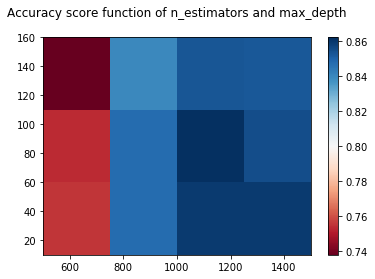

In [250]:
X,Y = meshgrid(n_estimators_values, max_depth_values)
Z = scores
im = imshow(Z,cmap=cm.RdBu,extent=[np.min(n_estimators_values), np.max(n_estimators_values), np.min(max_depth_values), np.max(max_depth_values)],aspect='auto')

plt.colorbar(im)
plt.title('Accuracy score function of n_estimators and max_depth\n')
#plt.axis([np.min(n_estimators_values), np.max(n_estimators_values), np.min(max_depth_values), np.max(max_depth_values)])
plt.show()

In [253]:
'''from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()'''

"from mpl_toolkits.mplot3d import Axes3D\nfrom matplotlib import cm\nfrom matplotlib.ticker import LinearLocator, FormatStrFormatter\nimport matplotlib.pyplot as plt\n\nfig = plt.figure()\nax = fig.gca(projection='3d')\nsurf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, \n                      cmap=cm.RdBu,linewidth=0, antialiased=False)\n\nax.zaxis.set_major_locator(LinearLocator(10))\nax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))\n\nfig.colorbar(surf, shrink=0.5, aspect=5)\n\nplt.show()"

Learning from our grid search analysis, we now know that a very high value of number of trees is needed to have a good classifier. Thus, we will choose n_estimators = 1000. As for the maximum depth of the trees, we will select max_depth = 110 which gave out the highest score in our above analysis. 

In [237]:
final_clf = RandomForestClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, random_state = 84, n_jobs=-1)

In [238]:
newsgroups_target_te_pred = final_clf.fit(newsgroups_data_tr,newsgroups_target_tr).predict(newsgroups_data_te)

In [239]:
final_acc_score = accuracy_score(newsgroups_target_te, newsgroups_target_te_pred)

In [240]:
final_acc_score

0.86219081272084808

**3- Display a confusion matrix of the classification pipeline**

In [241]:
from sklearn.metrics import confusion_matrix

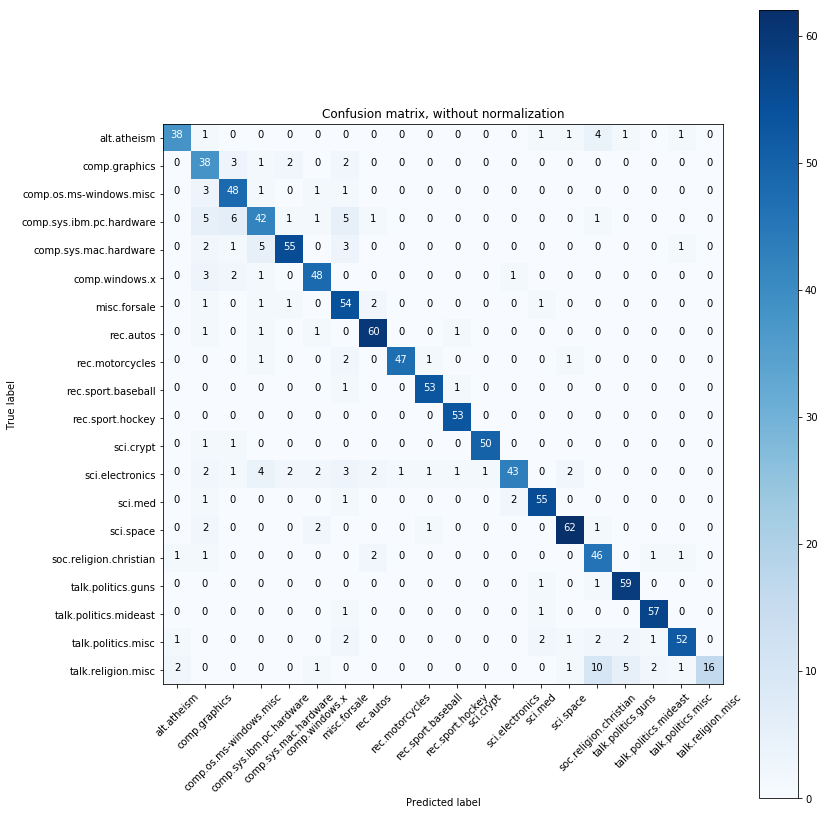

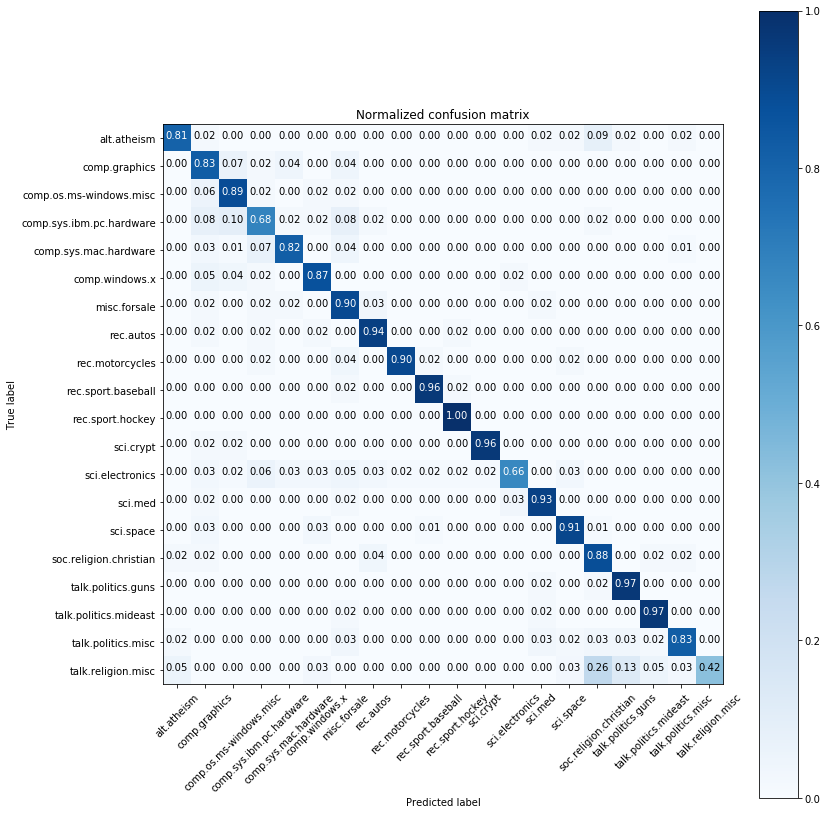

In [248]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'
    
    width = 12
    height = 12
    plt.figure(figsize=(width, height))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Retrieve class names from newsgroups data
class_names = newsgroups.target_names

# Compute confusion matrix
cnf_matrix = confusion_matrix(newsgroups_target_te, newsgroups_target_te_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [246]:
feature_importances_rf = final_clf.feature_importances_

In [247]:
feature_importances_rf.max()

0.0046486486728401395